<a href="https://colab.research.google.com/github/phuongtranuit/Google_colab/blob/main/aqi_model_cnn_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/ThuatToan/DeTai_code/Data/HN/'
paths = [f"{path}{filename}" for filename in os.listdir("/content/drive/MyDrive/ThuatToan/DeTai_code/Data/HN/")]
dfs = [pd.read_csv(path) for path in paths]
df = pd.concat(dfs)
df.sort_values(by=['Date (LT)'])
#Xử lý dữ liệu
df.index = np.arange(1, len(df) + 1)
df.drop('Site', axis=1, inplace=True)
df.drop('Parameter', axis=1, inplace=True)
df.drop('NowCast Conc.', axis=1, inplace=True)
df.drop('AQI Category', axis=1, inplace=True)
df.drop('Raw Conc.', axis=1, inplace=True)
df.drop('Conc. Unit', axis=1, inplace=True)
df.drop('Duration', axis=1, inplace=True)
df.drop('QC Name', axis=1, inplace=True)
df.loc[df['AQI'] <= 0, "AQI"]=0 # nếu AQI <=0 --> 0
df

,Date (LT),Year,Month,Day,Hour,AQI
1,2015-01-01 01:00 AM,2015,1,1,1,0
2,2015-01-01 02:00 AM,2015,1,1,2,0
3,2015-01-01 03:00 AM,2015,1,1,3,0
4,2015-01-01 04:00 AM,2015,1,1,4,0
5,2015-01-01 05:00 AM,2015,1,1,5,0
...,...,...,...,...,...,...
59530,2022-10-31 08:00 PM,2022,10,31,20,107
59531,2022-10-31 09:00 PM,2022,10,31,21,99
59532,2022-10-31 10:00 PM,2022,10,31,22,87
59533,2022-10-31 11:00 PM,2022,10,31,23,73


In [ ]:
df.rename(columns={'Date (LT)':'Timestamp'}, inplace=True)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df

,Timestamp,Year,Month,Day,Hour,AQI
1,2015-01-01 01:00:00,2015,1,1,1,0
2,2015-01-01 02:00:00,2015,1,1,2,0
3,2015-01-01 03:00:00,2015,1,1,3,0
4,2015-01-01 04:00:00,2015,1,1,4,0
5,2015-01-01 05:00:00,2015,1,1,5,0
...,...,...,...,...,...,...
59530,2022-10-31 20:00:00,2022,10,31,20,107
59531,2022-10-31 21:00:00,2022,10,31,21,99
59532,2022-10-31 22:00:00,2022,10,31,22,87
59533,2022-10-31 23:00:00,2022,10,31,23,73


In [ ]:
df.head()

,Timestamp,Year,Month,Day,Hour,AQI
1,2015-01-01 01:00:00,2015,1,1,1,0
2,2015-01-01 02:00:00,2015,1,1,2,0
3,2015-01-01 03:00:00,2015,1,1,3,0
4,2015-01-01 04:00:00,2015,1,1,4,0
5,2015-01-01 05:00:00,2015,1,1,5,0


In [ ]:
df['Date']=df["Timestamp"].dt.date

# Prediction Model - Dự Báo

* I tried to find the prediction model by each days average. So first, I made each days average data set.

In [ ]:
df_date=pd.DataFrame(df.groupby('Date')['AQI'].mean())
df_date

,AQI
Date,
2015-01-01,0.000000
2015-01-02,0.000000
2015-01-03,0.000000
2015-01-04,0.000000
2015-01-05,0.000000
...,...
2022-11-01,88.625000
2022-11-02,138.458333
2022-11-03,169.916667


* Time series by each days average

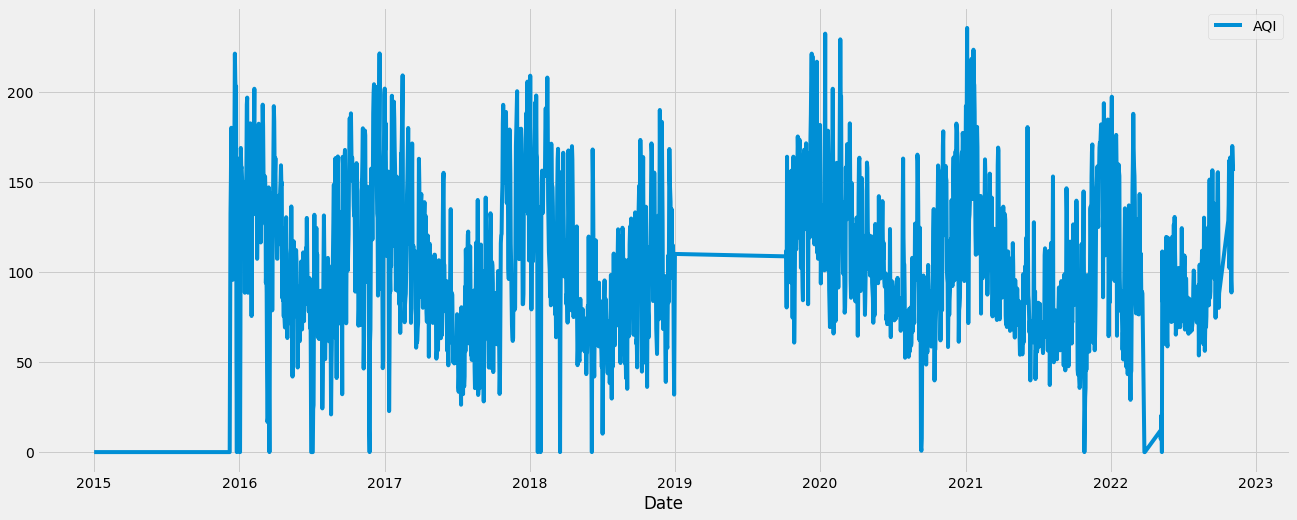

In [ ]:
df_date.plot(figsize=(20,8))

* Split data into train 80% and test 20%

In [ ]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2011

* Standardization by MinMaxScaler

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.72164219],
       [0.6903203 ],
       [0.6625376 ]])

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
len(train_data)
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])    

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1951, 60, 1)

* Modeling

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.fit(x_train,y_train, batch_size=100, epochs=1)

20/20 [==============================] - 1s 11ms/step - loss: 0.0382


* Prediction (dự báo)

In [ ]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

16/16 [==============================] - 0s 2ms/step


In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.8635120117756294

In [ ]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,AQI,Predictions
Date,,
2021-04-18,111.375000,102.932449
2021-04-19,87.875000,101.384552
2021-04-20,71.041667,99.725060
2021-04-21,72.750000,97.941978
2021-04-22,72.625000,99.830467
...,...,...
2022-11-01,88.625000,114.032578
2022-11-02,138.458333,112.211388
2022-11-03,169.916667,108.562279


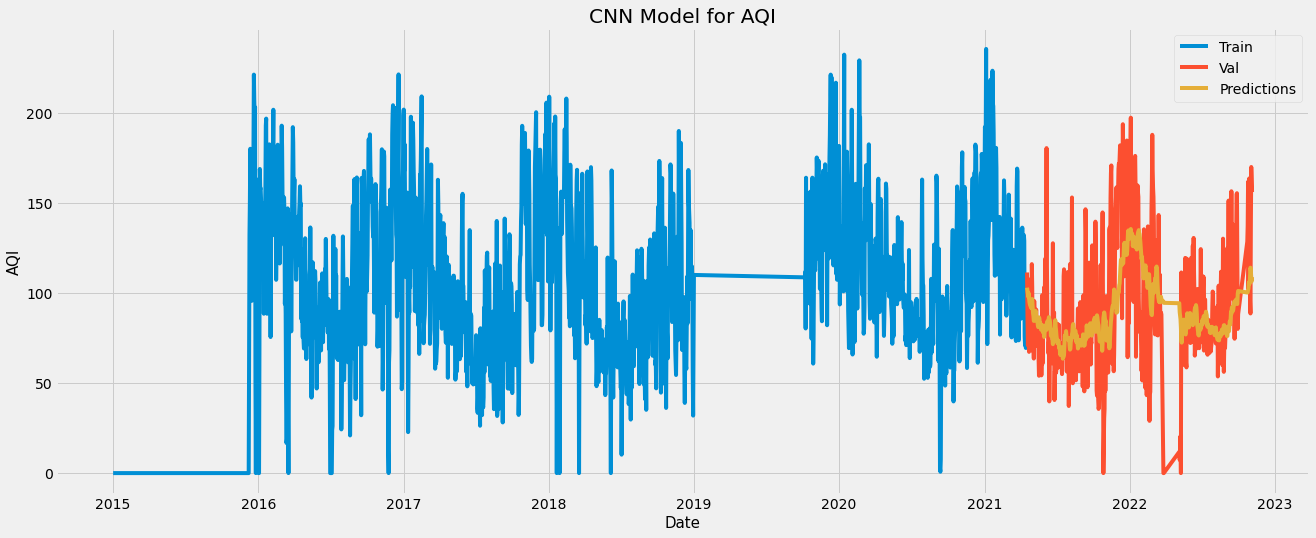

In [ ]:
plt.figure(figsize=(20,8))
plt.title("CNN Model for AQI")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("AQI",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['AQI'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])